# Covariance Matrix Prediction Using CNN + LSTM + DNN

Students names who have written this code: Prakhar Chaurasia,Vinay Chowdhary, Vinayak Sonkaramble (2021-22 Data science batch at NISM)





**Problem Statement** - Prediction of Var-Cov matrix of any selected portfolio

**Introduction:**
 Objective of this assignment is to predict VAR-COV matrix of any selected portfolio using Neural Networks architecture.
 Below mentioned analysis is done to predict next day VAR-COV matrix considering past 22 years daily returns data. This model can be further extended to predict entire months VAR-COV matrix.

 **Data Sets:**
  ProwessIQ database was used to download data of Nifty50 stocks of around 22 years. i.e. starting from 03-Jan-2000 to 22-Jul-2022.
  As part of data pre-processing, stock prices are converted to daily returns format.
  Data is split into training (80%) and testing (20%).
  Data is maintained in timeseries and is not shuffled.
  X is input of the architecture which is 250 days daily returns data.
  Y is nothing but calculated VAR-COV matrix for 251st day. Hence this model is a supervised regression model. As it is predicting 251st VAR-COV matrix with input of historical 250 days daily returns.

  $X \to \text{250 days daily return}$

  $Y\to \text{Var-Covar Matrix for 251$^{st}$ day}$

  **Architecture:**
  1. Input stock data in daily returns format was passed to Initial layer of Neural Networks. This initial layer is formed using **CNN (Convolutional Neural Network).** This layer extracts prominent features from input timeseries data. ***RELU*** activation function is used in the layer.
  2. Features extracted during initial layer are passed to subsequent layer of the architecture. This layer consists of 2 **LSTM layers (Long Short Term Memory)**. ***Tanh*** is the activation function used here.
  3. Finally output of LSTM layer is passed to **DNN (Deep Neural Network)** with 32 hidden units to learn hidden pattern in the data set and help improve prediction accuracy. ***Tanh*** is the activation function used here.
  4. **Loss function** for the model is ***Mean Squared Error***.


**Comments:**
    As seen in the graph below, **loss function** is reduced from **0.0866** to **0.0049.**
    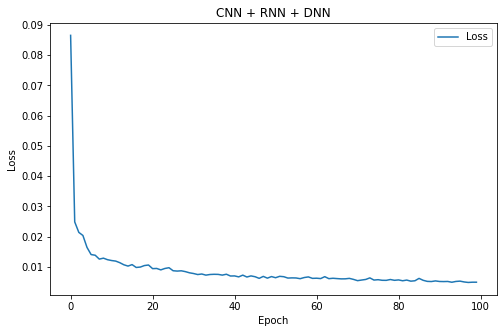

```
Predicted:
[[[0.69391525 0.10502066 0.04984848]
  [0.10502063 0.51633817 0.05879535]
  [0.04984848 0.05879534 0.29109767]]]

Actual:
[[[0.64716411 0.10389654 0.0723354 ]
  [0.10389654 0.31389394 0.09408829]
  [0.0723354  0.09408829 0.2673088 ]]]
```



In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, Reshape, TimeDistributed, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline

# Data from for 22 Years
!wget -O nifty_data.csv https://drive.google.com/uc?id=1rTI-ZcI2PiwGSKchh4krpzvcgUzUK-WW&export=download

data = pd.read_csv('nifty_data.csv', parse_dates={'dt':['Slot Date']}, index_col='dt', na_values=[' '],dtype=np.float64)

# Those stocks that are present in NIFTY50 ever since 2000.
stocks_of_interest = []
for col in data.columns:
  if data[col].isna().sum() < 7:
    stocks_of_interest.append(col)

stocks = data[stocks_of_interest].copy()
stocks.fillna(method='bfill', inplace=True)
stocks_daily_return = stocks.pct_change()
stocks_daily_return.dropna(inplace=True)

# Our portfolio choice
p = ['Apollo Hospitals Enterprise Ltd.', 'Shree Cement Ltd.', 'Dr. Reddy\'S Laboratories Ltd.'] #, 'State Bank Of India'] #, 'Wipro Ltd.']
portfolio = stocks_daily_return[p].copy()
portfolio_closing = stocks[p].iloc[1:].copy()

# Data preparation for model
X_temp = []
y_temp = []
days = 250
d = portfolio.shape[0]
for n in range(d-days+1):
  r_x = portfolio.iloc[n:n+days].values # [0: 250] 250 days
  r_y = portfolio.iloc[n+1:n+days+1].values # [1: 251] 250 days
  c = np.cov(r_y.T) # Var-Covar for 251th day
  X_temp.append(r_x)
  y_temp.append(c*1000)
X = np.array(X_temp)
y = np.array(y_temp)

# Splititng data into train and test
X_train = X[:round(X.shape[0]*0.8)].copy()
y_train = y[:round(X.shape[0]*0.8)].copy()
X_test = X[round(X.shape[0]*0.8):].copy()
y_test = y[round(X.shape[0]*0.8):].copy()

# CNN + RNN + DNN model
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(LSTM(units = 16, return_sequences = True))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(LSTM(units = 16, return_sequences = False))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense(32, activation=tf.keras.activations.tanh))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense((y.shape[1]*y.shape[2])))
model_cnn_lstm.add(Reshape((y.shape[1], y.shape[2])))
model_cnn_lstm.summary()

model_cnn_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, epochs=10) # Change epochs to 100

model_cnn_lstm.evaluate(X_test, y_test)

print(f'\nPredicted:\n{model_cnn_lstm.predict(X_test[-1:])}')
print(f'\nActual:\n{y_test[-1:]}')

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_cnn_lstm.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN + RNN + DNN')
plt.show()